In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import scipy.optimize as opt
import emcee
import corner

## Data

In [2]:
X = np.array([201, 244, 47, 287, 203, 58, 210, 202, 198, 158, 165, 201, 157, 131, 166, 160, 186, 125, 218, 146], dtype = float)
Y = np.array([592, 401, 583, 402, 495, 173, 479, 504, 510, 416, 393, 442, 317, 311, 400, 337, 423, 334, 533, 344], dtype = float)
sigma_Y = np.array([61, 25, 38, 15, 21, 15, 27, 14, 30, 16, 14, 25, 52, 16, 34, 31, 42, 26, 16, 22], dtype = float)
sigma_X = np.array([9, 4, 11, 7, 5, 9, 4, 4, 11, 7, 5, 5, 5, 6, 6, 5, 9, 8, 6, 5], dtype = float)
rho_XY = np.array([-0.84, 0.31, 0.64, -0.27, -0.33, 0.67, -0.02, -0.05, -0.84, -0.69, 0.30, -0.46, -0.03, 0.50, 0.73, -0.52, 0.90, 0.40, -0.78, -0.56], dtype = float)

## Standard Method

In [3]:
Y2 = Y
A2 = np.column_stack([np.ones_like(X), X])
C2 = np.diag(sigma_Y**2)
X2 = inv(A2.T @ inv(C2) @ A2) @ (A2.T @ inv(C2) @ Y2)
S2 = inv(A2.T @ inv(C2) @ A2)
print("b + m x = (%f +/- %f) + (%f +/- %f) x" % (X2[0], np.sqrt(S2[0][0]),
                                                 X2[1], np.sqrt(S2[1][1])))

b + m x = (213.273492 +/- 14.394033) + (1.076748 +/- 0.077407) x


In [10]:
# Jackknife
mi = []
bi = []
N = len(Y2)
for i in range(N):
    Aj = np.delete(A2, i, axis=0)
    Yj = np.delete(Y2, i, axis=0)
    sigma_j = np.delete(sigma_Y, i)
    Cj = np.diag(sigma_j**2)
    mi.append((inv(Aj.T @ inv(Cj)@Aj)@(Aj.T @ inv(Cj) @ Yj))[1])
    bi.append((inv(Aj.T @ inv(Cj)@Aj)@(Aj.T @ inv(Cj) @ Yj))[0])

Sj = np.diag([(N-1)*(np.sum((np.array(bi)-X2[0])**2))/N, (N-1)*(np.sum((np.array(mi)-X2[1])**2))/N])
print("The uncertainty by Jackknife is b + m x = (%f +/- %f) + (%f +/- %f) x" % (X2[0], np.sqrt(Sj[0][0]), X2[1], np.sqrt(Sj[1][1])))

The uncertainty by Jackknife is b + m x = (213.273492 +/- 155.048673) + (1.076748 +/- 0.874064) x


In [11]:
# Bootstrap -- i assume 20 trials mean here, as M=20
M = 20
mj = []
bj = []

for j in range(M):
    random_idx = np.random.choice(np.arange(0,20), size=20)
    Ab = A2[random_idx]
    Yb = Y2[random_idx]
    sigma_b = sigma_Y[random_idx]
    Cb = np.diag(sigma_b**2)
    mj.append((inv(Ab.T @ inv(Cb)@Ab)@(Ab.T @ inv(Cb) @ Yb))[1])
    bj.append((inv(Ab.T @ inv(Cb)@Ab)@(Ab.T @ inv(Cb) @ Yb))[0])

Sb = np.diag([(np.sum((np.array(bj)-X2[0])**2))/M, (np.sum((np.array(mj)-X2[1])**2))/M])
print("The uncertainty by Bootstrap is b + m x = (%f +/- %f) + (%f +/- %f) x" % (X2[0], np.sqrt(Sb[0][0]), X2[1], np.sqrt(Sb[1][1])))

The uncertainty by Bootstrap is b + m x = (213.273492 +/- 123.880309) + (1.076748 +/- 0.662208) x


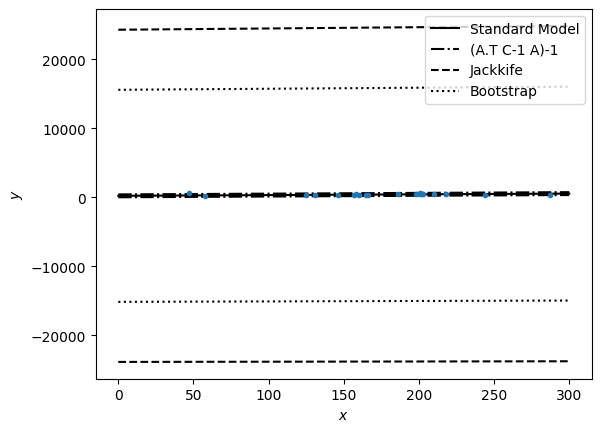

In [36]:
fig, ax= plt.subplots() 
ax.errorbar(X, Y, yerr = sigma_Y, marker = ".", linestyle = "");
ax.set_xlabel("$x$"); ax.set_ylabel("$y$");
# ax.set_xlim(0, 300);  ax.set_ylim(0, 700);

x = np.linspace(0, 300)
A = np.column_stack([np.ones_like(x), x])
y = A @ X2
ax.plot(x, y, color="k", label="Standard Model")

#plot different uncertainties
ax.plot(x, A @ (X2+np.diag(S2)), linestyle="-.", label="(A.T C-1 A)-1", color="k")
ax.plot(x, A @ (X2-np.diag(S2)), linestyle="-.", color="k")
ax.plot(x, A @ (X2+np.diag(Sj)), linestyle="--", label="Jackkife", color="k")
ax.plot(x, A @ (X2-np.diag(Sj)), linestyle="--", color="k")
ax.plot(x, A @ (X2+np.diag(Sb)), linestyle=":", label="Bootstrap", color="k")
ax.plot(x, A @ (X2-np.diag(Sb)), linestyle=":", color="k")

plt.legend()

plt.show()

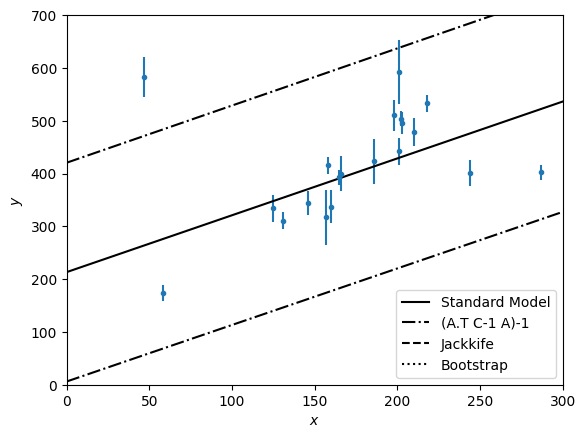

In [37]:
fig, ax= plt.subplots() 
ax.errorbar(X, Y, yerr = sigma_Y, marker = ".", linestyle = "");
ax.set_xlabel("$x$"); ax.set_ylabel("$y$");
ax.set_xlim(0, 300);  ax.set_ylim(0, 700);

x = np.linspace(0, 300)
A = np.column_stack([np.ones_like(x), x])
y = A @ X2
ax.plot(x, y, color="k", label="Standard Model")

#plot different uncertainties
ax.plot(x, A @ (X2+np.diag(S2)), linestyle="-.", label="(A.T C-1 A)-1", color="k")
ax.plot(x, A @ (X2-np.diag(S2)), linestyle="-.", color="k")
ax.plot(x, A @ (X2+np.diag(Sj)), linestyle="--", label="Jackkife", color="k")
ax.plot(x, A @ (X2-np.diag(Sj)), linestyle="--", color="k")
ax.plot(x, A @ (X2+np.diag(Sb)), linestyle=":", label="Bootstrap", color="k")
ax.plot(x, A @ (X2-np.diag(Sb)), linestyle=":", color="k")

plt.legend()

plt.show()

## MCMC

### Defining functions

In [39]:
def log_likelihood(x, y, sigma, b, m, Pb = 0.0, Yb = 0.0, Vb = 0.0):
  return np.sum( np.log( (1-Pb)* 1/np.sqrt(2*np.pi*sigma**2)        * np.exp(-(y-m*x-b)**2/(2*sigma**2))
                        + Pb   * 1/np.sqrt(2*np.pi*(Vb + sigma**2)) * np.exp(-(y-Yb)**2/(2*(Vb + sigma**2)))))

In [40]:
def prior (Pb, Vb):

    return 1.0/Vb

In [42]:
def log_prob(x0, x, y, sigma):
    if (x0[2]>=1) or (x0[2]<=0) or (x0[4] <=0) or (np.any(np.abs(x0) > 1000)):
        return -np.inf
    prob = log_likelihood(x, y, sigma, x0[0], x0[1], x0[2], x0[3], x0[4]) + np.log(prior(x0[2], x0[4]))
    if not np.isfinite(prob):
        return -np.inf
    else:
        return prob

In [43]:
def metropolis_hastings(log_likelihood, acceptance, prior, transition, x0, iterations = 1000):
    x_old = x0
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new = transition(x_old)
        L_old = log_likelihood(x_old)
        L_new = log_likelihood(x_new) 
        if (acceptance(L_old + np.log(prior(x_old)), L_new + np.log(prior(x_new)))):            
            x_old = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)

    return np.array(accepted), np.array(rejected)

### Custom

In [44]:
x0 = np.array([34., 2.2, 0.0, 0.0, 0.0])
s0 = np.array([10.0, 0.1, 0.2, 100.0, 100.0])
iterations = 1000000
accepted, rejected = metropolis_hastings(lambda x: log_likelihood(X, Y, sigma_Y, x[0], x[1], x[2], x[3], x[4]),
                                         lambda L_old, L_new: (np.random.uniform(0,1) < np.exp(L_new - L_old)), 
                                         lambda x: 0.0 if (x[2] <= 0 or x[2] >= 1 or x[4] <= 0) else 1.0 / x[4],
                                         lambda x: np.random.normal(x, s0),
                                         x0, iterations)

/var/folders/mp/7xhn2jq112z6td9nlqyw8mvm0000gn/T/ipykernel_19360/3865209980.py:9: RuntimeWarning: divide by zero encountered in log
  if (acceptance(L_old + np.log(prior(x_old)), L_new + np.log(prior(x_new)))):
/var/folders/mp/7xhn2jq112z6td9nlqyw8mvm0000gn/T/ipykernel_19360/3871569432.py:5: RuntimeWarning: invalid value encountered in scalar subtract
  lambda L_old, L_new: (np.random.uniform(0,1) < np.exp(L_new - L_old)),
/var/folders/mp/7xhn2jq112z6td9nlqyw8mvm0000gn/T/ipykernel_19360/3860183971.py:2: RuntimeWarning: invalid value encountered in log
  return np.sum( np.log( (1-Pb)* 1/np.sqrt(2*np.pi*sigma**2)        * np.exp(-(y-m*x-b)**2/(2*sigma**2))
/var/folders/mp/7xhn2jq112z6td9nlqyw8mvm0000gn/T/ipykernel_19360/3860183971.py:3: RuntimeWarning: invalid value encountered in sqrt
  + Pb   * 1/np.sqrt(2*np.pi*(Vb + sigma**2)) * np.exp(-(y-Yb)**2/(2*(Vb + sigma**2)))))
/var/folders/mp/7xhn2jq112z6td9nlqyw8mvm0000gn/T/ipykernel_19360/3860183971.py:3: RuntimeWarning: overflow encounter

In [45]:
print(100.0 * accepted.shape[0] / (accepted.shape[0] + rejected.shape[0]), "% acceptance rate (target is 50%)")

12.082 % acceptance rate (target is 50%)


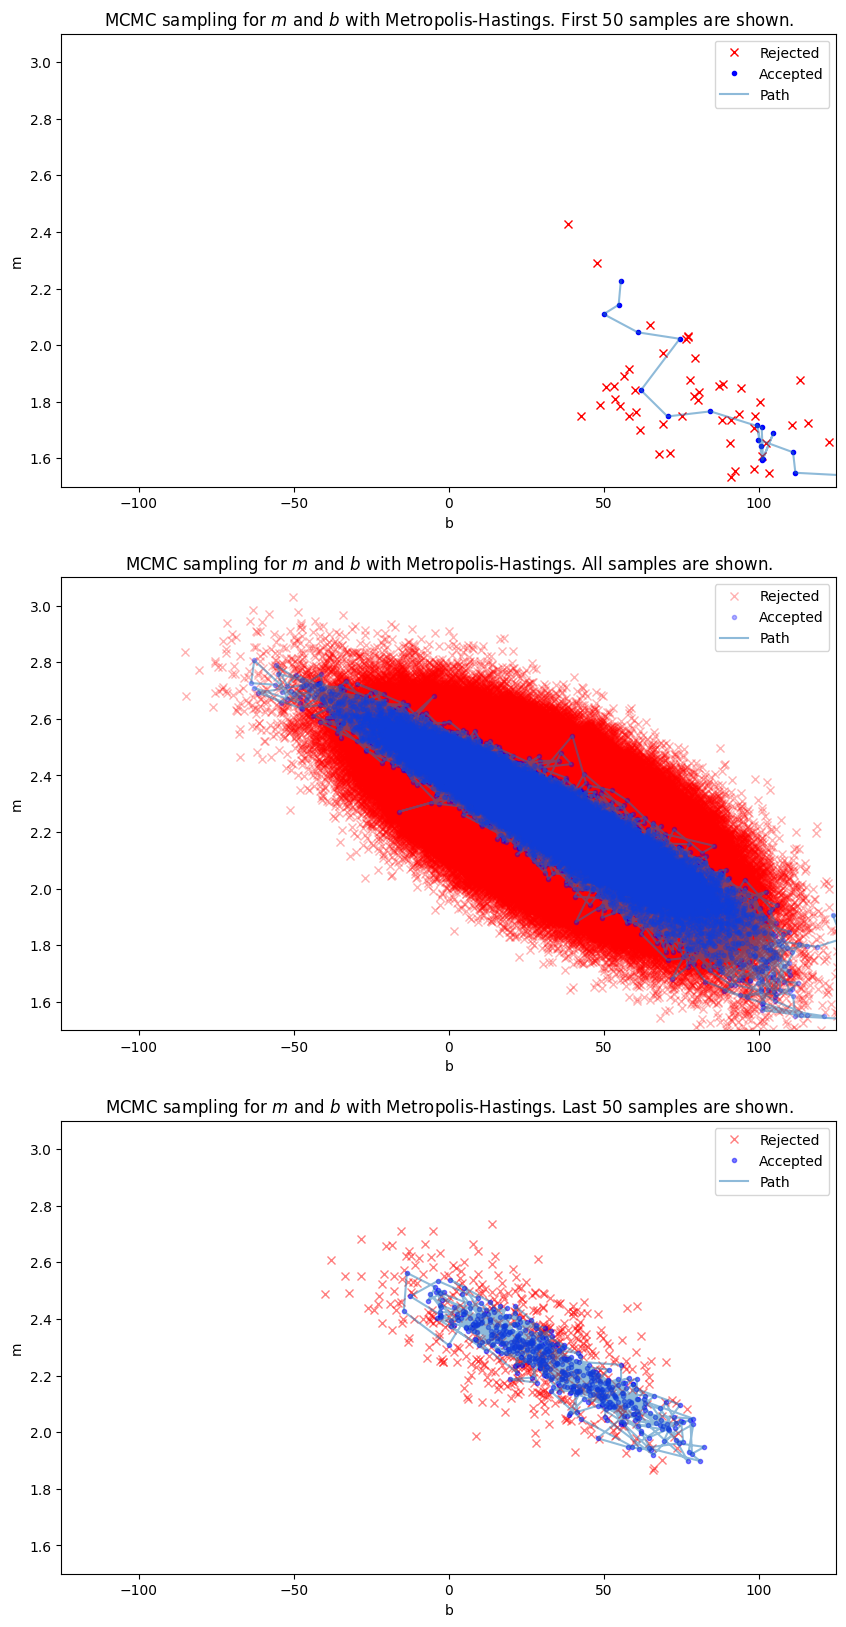

In [46]:
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(3,1,1)
ax.plot(rejected[:50,0], rejected[:50,1], 'rx', label = 'Rejected')
ax.plot(accepted[:50,0], accepted[:50,1], 'b.', label = 'Accepted')
ax.plot(accepted[:50,0], accepted[:50,1], label = "Path", alpha = 0.5)
ax.set_xlabel("b");
ax.set_ylabel("m");
ax.set_xlim(-125.0, +125.0);
ax.set_ylim(1.5, 3.1);
ax.legend()
ax.set_title("MCMC sampling for $m$ and $b$ with Metropolis-Hastings. First 50 samples are shown."); 

ax = fig.add_subplot(3,1,2)
ax.plot(rejected[:,0], rejected[:,1], 'rx', label = 'Rejected', alpha = 0.3)
ax.plot(accepted[:,0], accepted[:,1], 'b.', label = 'Accepted', alpha = 0.3)
ax.plot(accepted[:,0], accepted[:,1], label = "Path", alpha = 0.5)
ax.set_xlabel("b");
ax.set_ylabel("m");
ax.set_xlim(-125.0, +125.0);
ax.set_ylim(1.5, 3.1);
ax.legend()
ax.set_title("MCMC sampling for $m$ and $b$ with Metropolis-Hastings. All samples are shown.");

to_show = 500
ax = fig.add_subplot(3,1,3)
ax.plot(rejected[-to_show:,0], rejected[-to_show:,1], 'rx', label = 'Rejected', alpha = 0.5)
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], 'b.', label = 'Accepted', alpha = 0.5)
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], label = "Path", alpha = 0.5)
ax.set_xlabel("b");
ax.set_ylabel("m");
ax.set_xlim(-125.0, +125.0);
ax.set_ylim(1.5, 3.1);
ax.legend()
ax.set_title("MCMC sampling for $m$ and $b$ with Metropolis-Hastings. Last 50 samples are shown.");

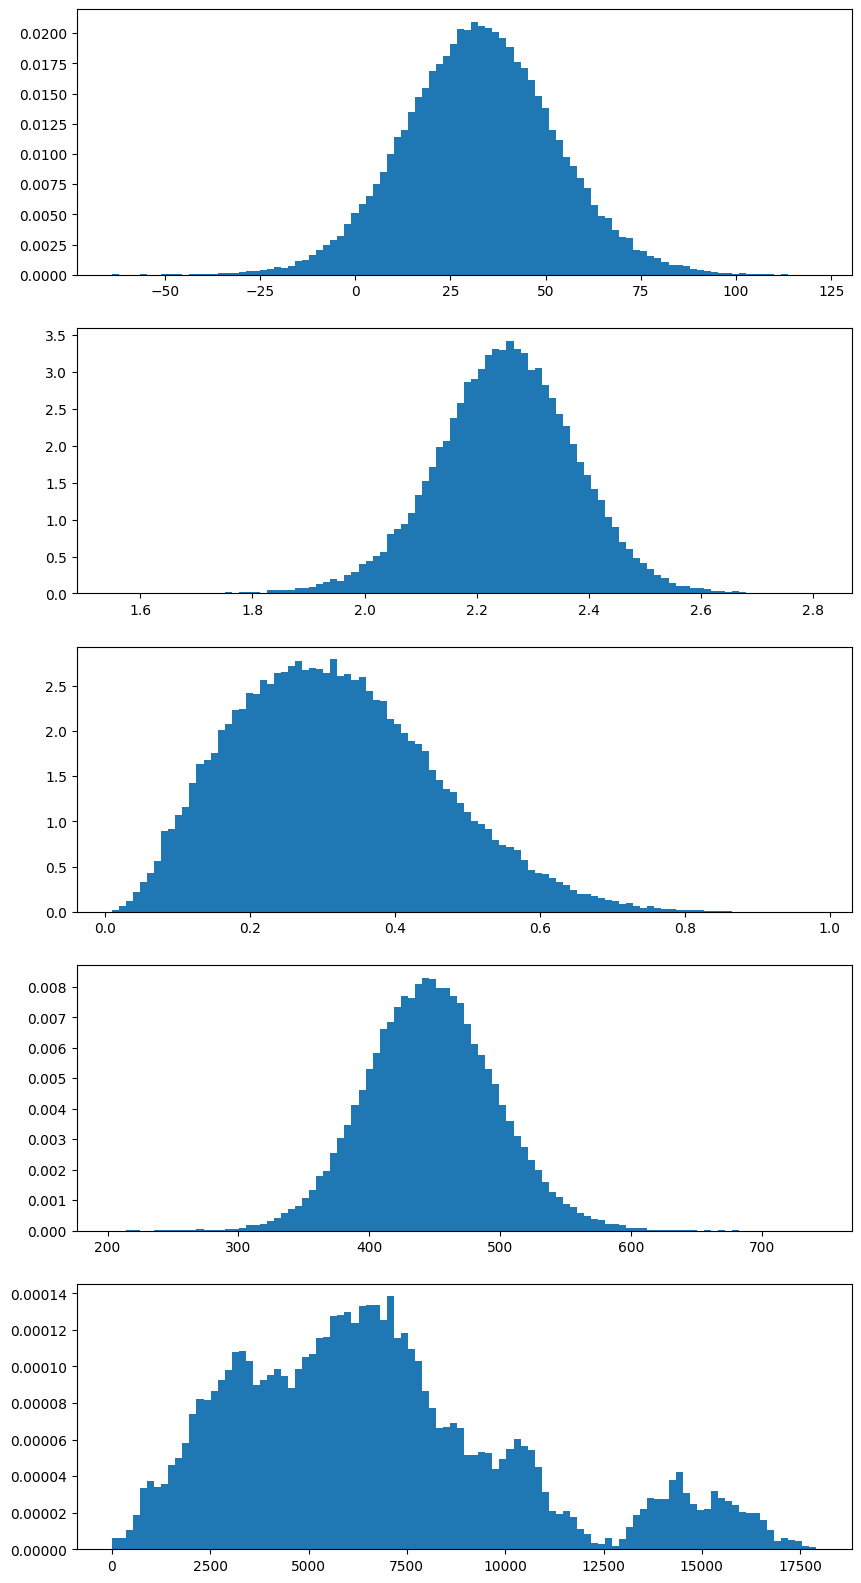

In [47]:
num_accepted = accepted.shape[0]

fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(5,1,1)
plt.hist(accepted[int(0.5*num_accepted):,0], density = True, bins = 100);
ax = fig.add_subplot(5,1,2)
plt.hist(accepted[int(0.5*num_accepted):,1], density = True, bins = 100);
ax = fig.add_subplot(5,1,3)
plt.hist(accepted[int(0.5*num_accepted):,2], density = True, bins = 100);
ax = fig.add_subplot(5,1,4)
plt.hist(accepted[int(0.5*num_accepted):,3], density = True, bins = 100);
ax = fig.add_subplot(5,1,5)
plt.hist(accepted[int(0.5*num_accepted):,4], density = True, bins = 100);

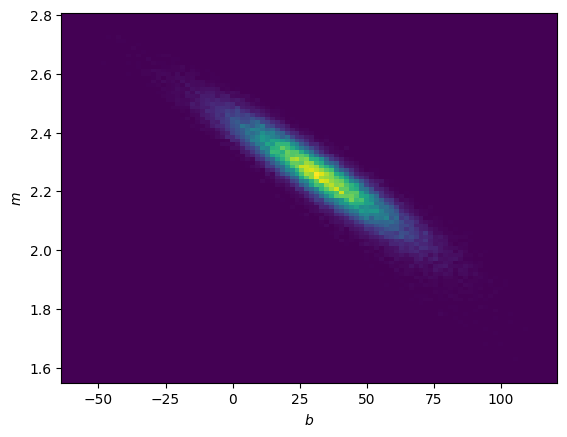

In [48]:
counts, xbins, ybins, image = plt.hist2d(accepted[int(0.5*num_accepted):,0],
                                         accepted[int(0.5*num_accepted):,1],
                                         bins = 100)
plt.xlabel("$b$"); plt.ylabel("$m$");

b + m x = (32.741036 +/- 19.958483) + (2.251348 +/- 0.125190) x


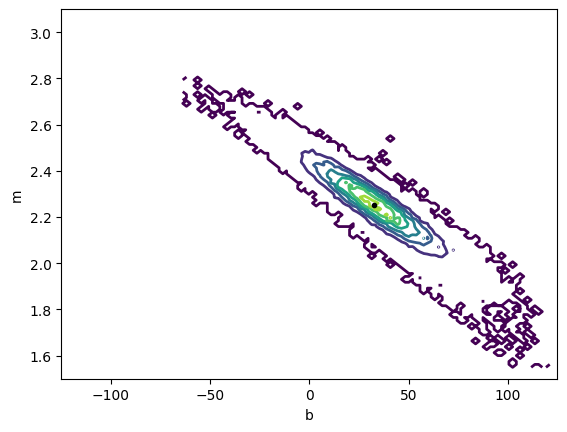

In [49]:
plt.contour(counts.T, extent = [xbins.min(), xbins.max(), ybins.min(), ybins.max()], linewidths = 2)
plt.xlabel("b"); plt.ylabel("m")
plt.xlim(-125.0, +125.0);
plt.ylim(1.5, 3.1);
plt.plot(np.mean(accepted[int(0.5*num_accepted):,0]), np.mean(accepted[int(0.5*num_accepted):,1]), '.k')
print("b + m x = (%f +/- %f) + (%f +/- %f) x" % (np.mean(accepted[int(0.5*num_accepted):,0]), np.std(accepted[int(0.5*num_accepted):,0]),
                                                 np.mean(accepted[int(0.5*num_accepted):,1]), np.std(accepted[int(0.5*num_accepted):,1])))

### emcee

In [54]:
nwalkers = 20
ndim = 5

x0_mean = np.array([34., 2.2, 0.0, 0.0, 0.0])
# Add small random noise to initialize each walker near x0_mean
x0 = x0_mean + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[X, Y, sigma_Y])

In [55]:
state = sampler.run_mcmc(x0, 100)
sampler.reset()
sampler.run_mcmc(state, 20000)

State([[ 2.46825529e+01  2.31437999e+00  3.77728661e-01  4.63242667e+02
   3.90057172e+02]
 [ 2.00615367e+02  1.11827463e+00  7.32585903e-02 -4.31544482e+02
   2.94620091e+01]
 [ 1.81285864e+01  2.32256182e+00  1.43921937e-01  4.32991114e+02
   2.29071692e+02]
 [ 3.50362938e+01  2.21874175e+00  3.68339106e-01  4.53018993e+02
   2.78129258e+02]
 [ 5.16709785e+01  2.20313242e+00  4.25811882e-01  4.25589626e+02
   6.92374876e+02]
 [ 8.54726303e+01  1.96409429e+00  4.45108423e-01  4.15137416e+02
   7.87305966e+02]
 [ 5.33728164e+01  2.12562552e+00  1.75261251e-01  4.21692613e+02
   3.25841827e+02]
 [ 1.80399715e+01  2.31973762e+00  3.94275543e-01  4.46824273e+02
   3.75694808e+02]
 [ 2.01766666e+01  2.32850322e+00  1.83037102e-01  4.16845675e+02
   1.65043802e+00]
 [ 5.03045890e+01  2.15693001e+00  1.32352783e-01  4.15066525e+02
   5.15121473e-08]
 [ 3.67466188e+01  2.18482584e+00  2.40993457e-01  4.10530521e+02
   5.95710497e-04]
 [ 2.92875502e+01  2.25828503e+00  1.39119576e-01  4.295968

In [56]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.321


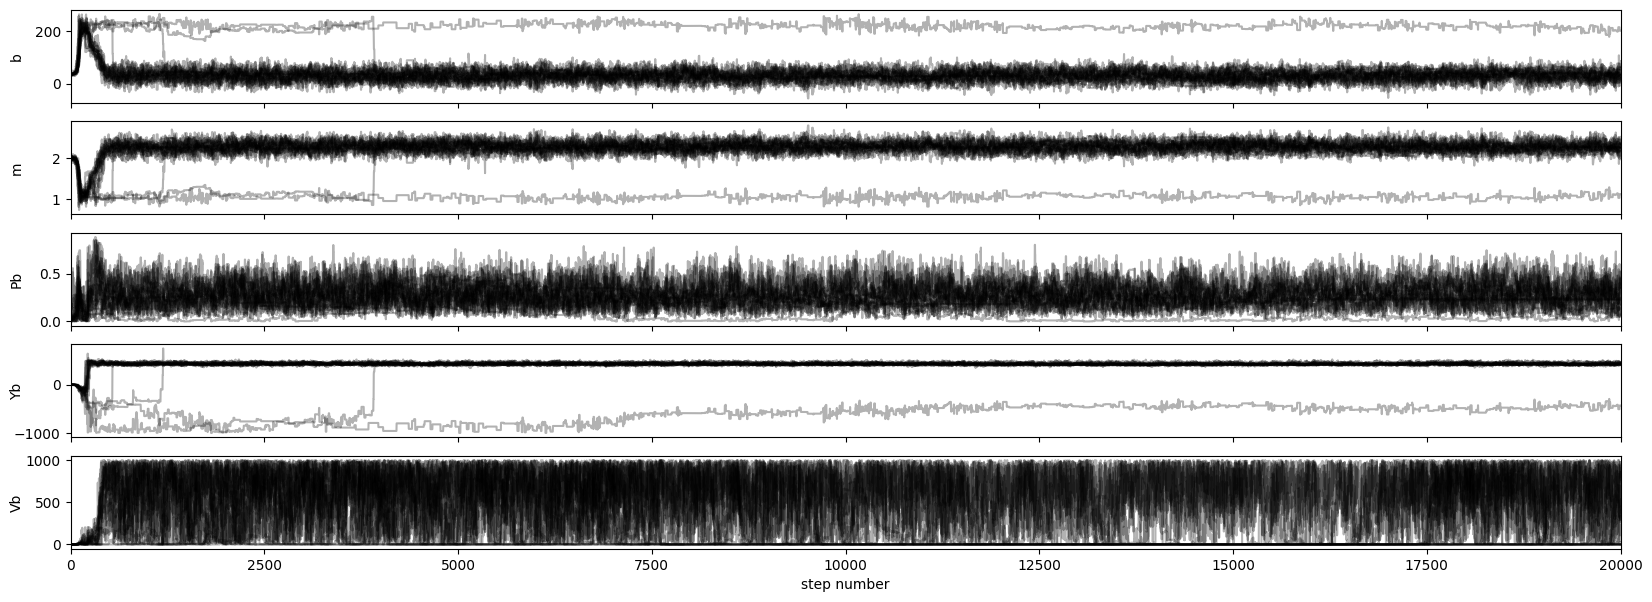

In [57]:
fig, axes = plt.subplots(5, figsize=(20, 7), sharex=True)
samples = sampler.get_chain()
labels = ["b", "m", "Pb", "Yb", "Vb"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.03, 0.5)

axes[-1].set_xlabel("step number");

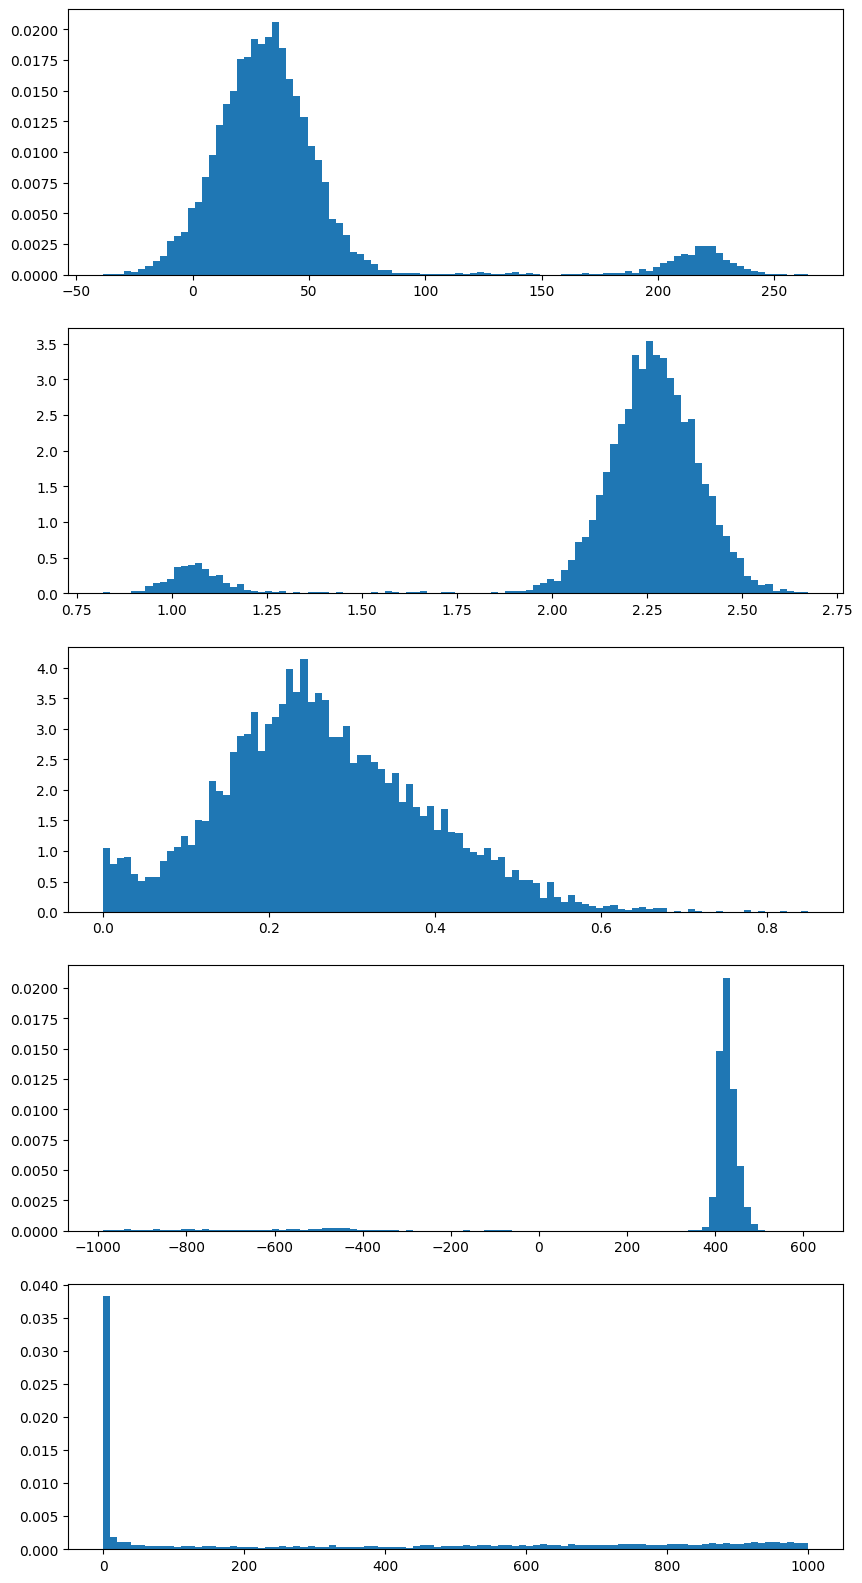

In [69]:
samples = sampler.get_chain(discard=100, thin=50, flat=True)

fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(5,1,1)
plt.hist(samples[:,0], density = True, bins = 100);
ax = fig.add_subplot(5,1,2)
plt.hist(samples[:,1], density = True, bins = 100);
ax = fig.add_subplot(5,1,3)
plt.hist(samples[:,2], density = True, bins = 100);
ax = fig.add_subplot(5,1,4)
plt.hist(samples[:,3], density = True, bins = 100);
ax = fig.add_subplot(5,1,5)
plt.hist(samples[:,4], density = True, bins = 100);

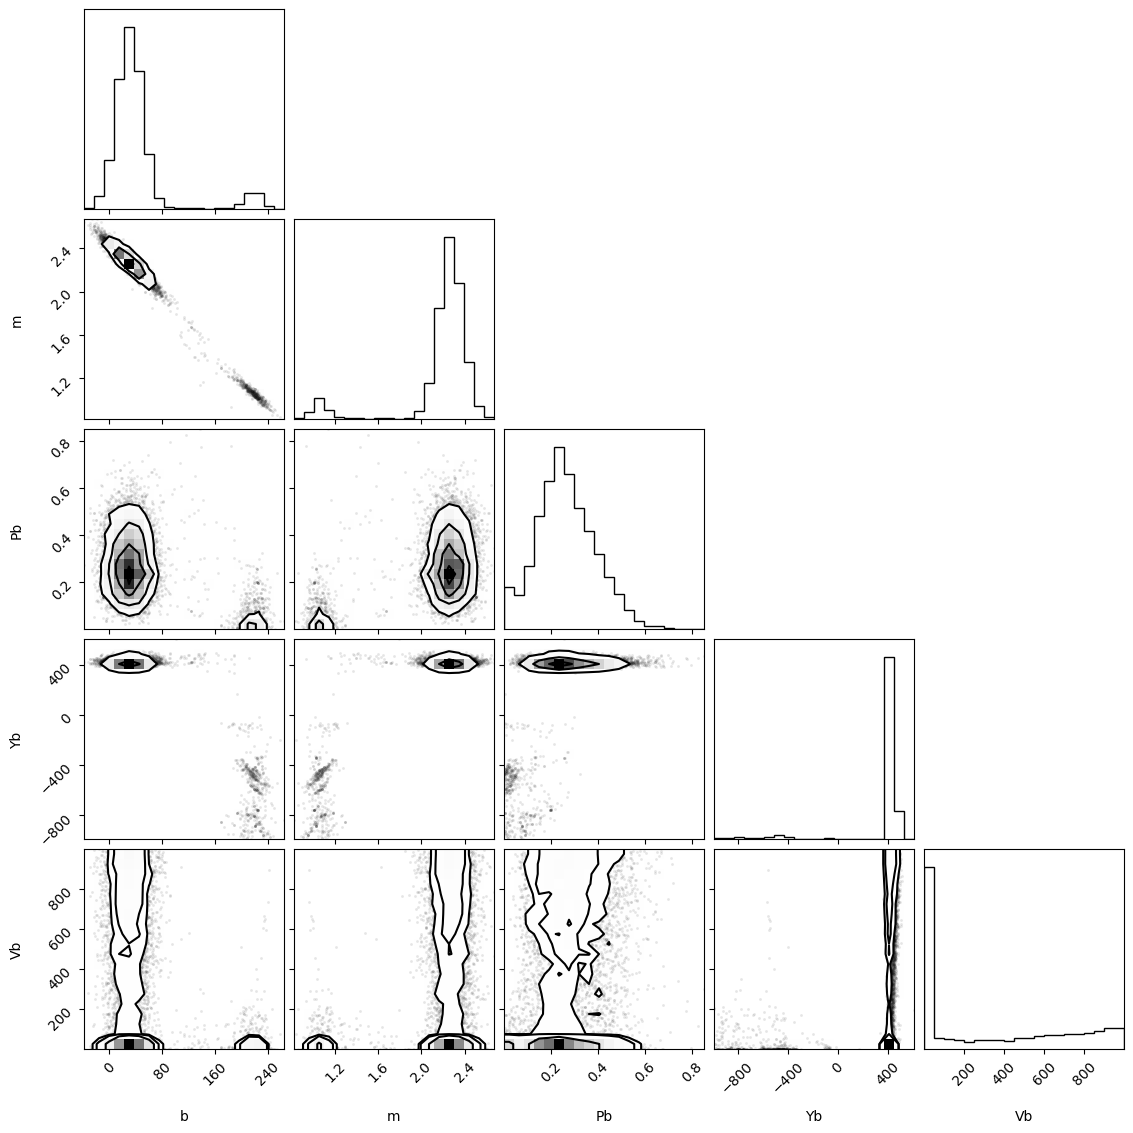

In [70]:
fig = corner.corner(
    samples, labels=labels
);

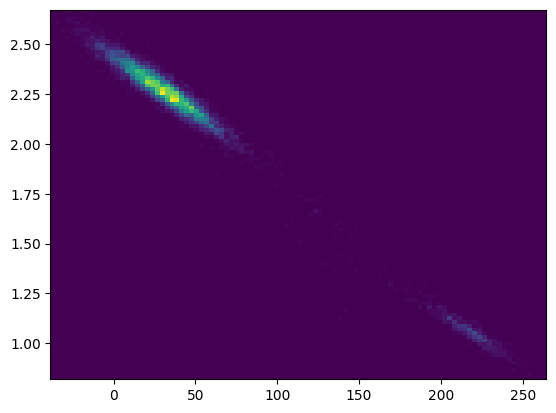

In [71]:
counts, xbins, ybins, image = plt.hist2d(samples[:,0],
                                         samples[:,1],
                                         bins = 100)

b + m x = (43.362639 +/- 50.873632) + (2.184379 +/- 0.326358) x


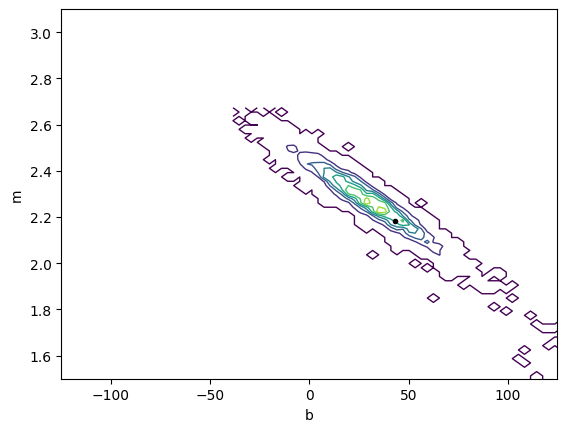

In [72]:
plt.contour(counts.T, extent = [xbins.min(), xbins.max(), ybins.min(), ybins.max()], linewidths = 1)
plt.xlabel("b"); plt.ylabel("m")
plt.xlim(-125.0, +125.0);
plt.ylim(1.5, 3.1);
plt.plot(np.mean(samples[:,0]), np.mean(samples[:,1]), '.k')
print("b + m x = (%f +/- %f) + (%f +/- %f) x" % (np.mean(samples[:,0]), np.std(samples[:,0]),
                                                 np.mean(samples[:,1]), np.std(samples[:,1])))

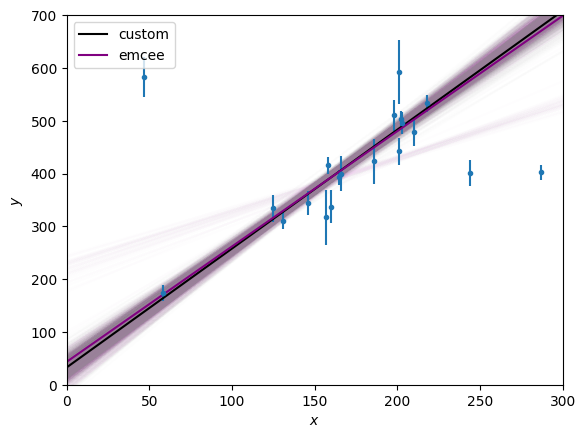

In [85]:
x = np.linspace(0, 300)
A = np.column_stack([np.ones_like(x), x])
for i in np.random.randint(int(0.8*num_accepted), num_accepted, 1000):
  y = A @ np.array([accepted[i,0], accepted[i,1]])
  plt.plot(x, y, color = 'gray', alpha = 0.01);

for i in np.random.randint(len(samples), size=500):
  y = A @ np.array([samples[i,0], samples[i,1]])
  plt.plot(x, y, color = 'violet', alpha = 0.01);

plt.errorbar(X, Y, yerr = sigma_Y, marker = ".", linestyle = "");
plt.xlabel("$x$"); plt.ylabel("$y$");
plt.xlim(0, 300);  plt.ylim(0, 700);

y = A @ np.array([np.mean(accepted[int(0.5*num_accepted):,0]), np.mean(accepted[int(0.5*num_accepted):,1])])
plt.plot(x, y, color='k', label="custom");
  
y = A @ np.array([np.mean(samples[:,0]), np.mean(samples[:,1])])
plt.plot(x, y, color='purple', label="emcee");

plt.legend();